In [1]:
'''
This script shows how to predict stock prices using a basic RNN
'''
import tensorflow as tf
import numpy as np
import matplotlib
import os
import pandas as pd

tf.set_random_seed(777)  # reproducibility

if "DISPLAY" not in os.environ:
    # remove Travis CI Error
    matplotlib.use('Agg')

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

def MinMaxScaler(data):
    ''' Min Max Normalization
    Parameters
    ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]
    Returns
    ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]
    References
    ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
    '''
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)


# train Parameters
seq_length = 5
data_dim = 16
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

# Open, High, Low, Volume, Close
# xy = np.loadtxt('data-02-stock_daily.csv', delimiter=',')
xy = pd.read_excel('전북.xlsx')
# xy = pd.get_dummies(xy, columns=['상대팀'])
# xy = xy[::-1]  # reverse order (chronically ordered)
print("-------------------------------------")
print(xy)
print("-------------------------------------")
# train/test split
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]  # Index from [train_size - seq_length] to utilize past sequence

train_set = np.array(train_set).astype(np.int)
test_set = np.array(test_set).astype(np.int)

train_set

-------------------------------------
    대구  수원  강원  포항  경남  인천  제주  상주  서울  성남  울산  홈어웨이  전 경기  득  실  승무패
0    1   0   0   0   0   0   0   0   0   0   0     1    13  1  1    1
1    0   1   0   0   0   0   0   0   0   0   0     0     8  4  0    3
2    0   0   1   0   0   0   0   0   0   0   0     1     9  0  1    0
3    0   0   0   1   0   0   0   0   0   0   0     1    13  2  0    3
4    0   0   0   0   1   0   0   0   0   0   0     0     3  3  3    1
5    0   0   0   0   0   1   0   0   0   0   0     1     4  2  0    3
6    0   0   0   0   0   0   1   0   0   0   0     0     7  1  0    3
7    0   0   0   0   0   0   0   1   0   0   0     0     7  3  0    3
8    0   0   0   0   0   0   0   0   1   0   0     1     8  2  1    3
9    0   0   0   0   0   0   0   0   0   1   0     0     6  0  0    1
10   0   0   0   0   0   0   0   0   0   0   1     0     6  1  2    0
11   0   0   0   0   0   0   1   0   0   0   0     1     8  3  1    3
12   0   0   0   0   1   0   0   0   0   0   0     1

array([[ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 13,  1,  1,  1],
       [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  4,  0,  3],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  9,  0,  1,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  1, 13,  2,  0,  3],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  3,  3,  3,  1],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  4,  2,  0,  3],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  7,  1,  0,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  7,  3,  0,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  8,  2,  1,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  6,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  6,  1,  2,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  1,  8,  3,  1,  3],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  6,  4,  1,  3],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,

In [3]:
# Scale each
# train_set = MinMaxScaler(train_set)
# test_set = MinMaxScaler(test_set)

In [4]:
train_set

array([[ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 13,  1,  1,  1],
       [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  4,  0,  3],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  9,  0,  1,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  1, 13,  2,  0,  3],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  3,  3,  3,  1],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  4,  2,  0,  3],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  7,  1,  0,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  7,  3,  0,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  8,  2,  1,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  6,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  6,  1,  2,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  1,  8,  3,  1,  3],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  6,  4,  1,  3],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,

In [5]:
trainX = train_set[:, :-1]
trainY = train_set[:, -1:]


In [6]:
testX = test_set[:, :-1]
testY = test_set[:, -1:]

[[ 1  0  0  0  0  0  0  0  0  0  0  1 13  1  1  1]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  8  4  0  3]
 [ 0  0  1  0  0  0  0  0  0  0  0  1  9  0  1  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  1 13  2  0  3]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  3  3  3  1]] -> [3]
[[ 0  1  0  0  0  0  0  0  0  0  0  0  8  4  0  3]
 [ 0  0  1  0  0  0  0  0  0  0  0  1  9  0  1  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  1 13  2  0  3]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  3  3  3  1]
 [ 0  0  0  0  0  1  0  0  0  0  0  1  4  2  0  3]] -> [3]
[[ 0  0  1  0  0  0  0  0  0  0  0  1  9  0  1  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  1 13  2  0  3]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  3  3  3  1]
 [ 0  0  0  0  0  1  0  0  0  0  0  1  4  2  0  3]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  7  1  0  3]] -> [3]
[[ 0  0  0  1  0  0  0  0  0  0  0  1 13  2  0  3]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  3  3  3  1]
 [ 0  0  0  0  0  1  0  0  0  0  0  1  4  2  0  3]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  7  1  0  3]
 [ 0  0

[step: 87] loss: 0.5924614071846008
[step: 88] loss: 0.5573309063911438
[step: 89] loss: 0.5243551135063171
[step: 90] loss: 0.4937402307987213
[step: 91] loss: 0.4653419256210327
[step: 92] loss: 0.43875277042388916
[step: 93] loss: 0.41350194811820984
[step: 94] loss: 0.38924744725227356
[step: 95] loss: 0.3658692240715027
[step: 96] loss: 0.34345245361328125
[step: 97] loss: 0.32217833399772644
[step: 98] loss: 0.3021952211856842
[step: 99] loss: 0.2835320830345154
[step: 100] loss: 0.26607972383499146
[step: 101] loss: 0.24965280294418335
[step: 102] loss: 0.23407481610774994
[step: 103] loss: 0.21924985945224762
[step: 104] loss: 0.20517657697200775
[step: 105] loss: 0.1919105350971222
[step: 106] loss: 0.1795017123222351
[step: 107] loss: 0.1679472178220749
[step: 108] loss: 0.15718016028404236
[step: 109] loss: 0.14709678292274475
[step: 110] loss: 0.137599915266037
[step: 111] loss: 0.12863019108772278
[step: 112] loss: 0.12017334252595901
[step: 113] loss: 0.11224403232336044


[step: 337] loss: 2.0851932276855223e-05
[step: 338] loss: 2.005026544793509e-05
[step: 339] loss: 1.928281744767446e-05
[step: 340] loss: 1.8540651581133716e-05
[step: 341] loss: 1.7824875612859614e-05
[step: 342] loss: 1.7135616872110404e-05
[step: 343] loss: 1.6472640709253028e-05
[step: 344] loss: 1.5832854842301458e-05
[step: 345] loss: 1.5216711290122475e-05
[step: 346] loss: 1.46230913742329e-05
[step: 347] loss: 1.4054743587621488e-05
[step: 348] loss: 1.3502343790605664e-05
[step: 349] loss: 1.2971936484973412e-05
[step: 350] loss: 1.246351621375652e-05
[step: 351] loss: 1.1971292224188801e-05
[step: 352] loss: 1.1498830644995905e-05
[step: 353] loss: 1.104377952287905e-05
[step: 354] loss: 1.0609361197566614e-05
[step: 355] loss: 1.018630700855283e-05
[step: 356] loss: 9.780164873518515e-06
[step: 357] loss: 9.389917977387086e-06
[step: 358] loss: 9.01437579159392e-06
[step: 359] loss: 8.65583115228219e-06
[step: 360] loss: 8.307222742587328e-06
[step: 361] loss: 7.9746341725

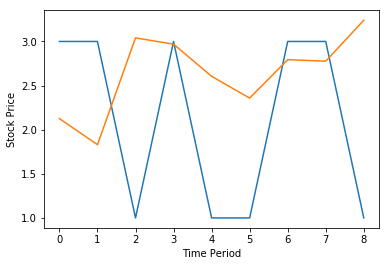

In [7]:

# Scale each
# train_set = MinMaxScaler(train_set)
# test_set = MinMaxScaler(test_set)
# # build datasets
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
#         print(i, len(time_series), seq_length)
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)
# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

In [8]:
test_predict

array([[2.1259098],
       [1.8301088],
       [3.0404623],
       [2.9694128],
       [2.605259 ],
       [2.3581324],
       [2.7935624],
       [2.7764425],
       [3.240519 ]], dtype=float32)